# Exercise 1 - Forecasting demand model 

## Key concepts

### Time series

A time series is a sequence of data collected at successive time intervals, usually evenly spaced.

### Time series forecasting

Time series forecasting involves forecasting and extrapolating future trends or values based on old data points (supervised time-series forecasting), clustering them into groups, and predicting future patterns (unsupervised time-series forecasting)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

from dotenv import load_dotenv

In [2]:
_ = load_dotenv()

## Load data from csv file

In [3]:
path = os.getenv("TIME_SERIES_PATH")

data = pd.read_csv(path)

data.head()

,year_month,Demand
0,2017-01,1211.009490
1,2017-02,1660.584649
2,2017-03,3182.587014
3,2017-04,3506.515270
4,2017-05,4554.082280


In [4]:
data.columns = ["Date", "Demand"]

data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)

In [5]:
print(data.isnull().sum())
print(data.describe())

Demand    0
dtype: int64
            Demand
count    64.000000
mean   2600.044986
std    1943.995938
min     217.314949
25%    1034.370651
50%    1947.817229
75%    4216.465081
max    7686.307292


## Normalization of data using StandardScaler

Standardization involves rescaling the features so that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one

Standardizing the data can improve the performance of machine learning algorithms by ensuring that each feature contributes equally to the model.

In [6]:
standard_scaler = StandardScaler()

df = data.copy()

df["Demand"] = standard_scaler.fit_transform(df[["Demand"]])

## Visualize standared data

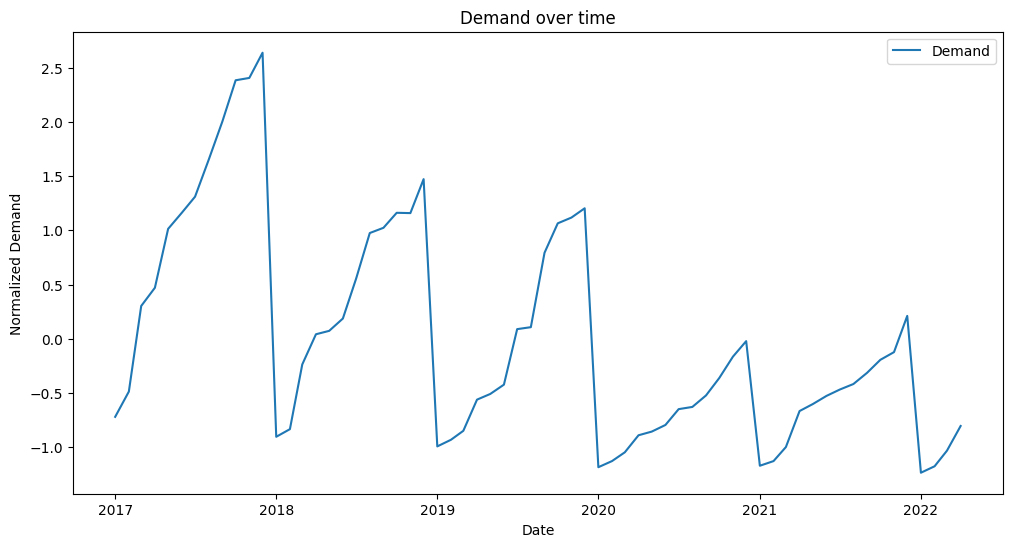

In [7]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(df["Demand"], label="Demand")
plt.title("Demand over time")
plt.xlabel("Date")
plt.ylabel("Normalized Demand")
plt.legend()
plt.show()

## Decomposition of a time series

Decomposition of a time series can be performed by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual term.

Additive time series:

Value = Base Level + Trend + Seasonality + Error

### Trend

Represents the general direction of the data in the long term. It can be increasing, decreasing or constant.

### Seasonality

Shows the repetitive and predictable fluctuations within the time series. These fluctuations usually occur in a specific period

Captures recurring cyclical patterns in the data. For example, an increase in demand in certain months of the year. If you see a clear pattern in this graph, you can deduce that demand has a significant seasonal component.

### Residual

They are random fluctuations that cannot be explained by trend or seasonality. They represent the error or variability not explained by the additive model

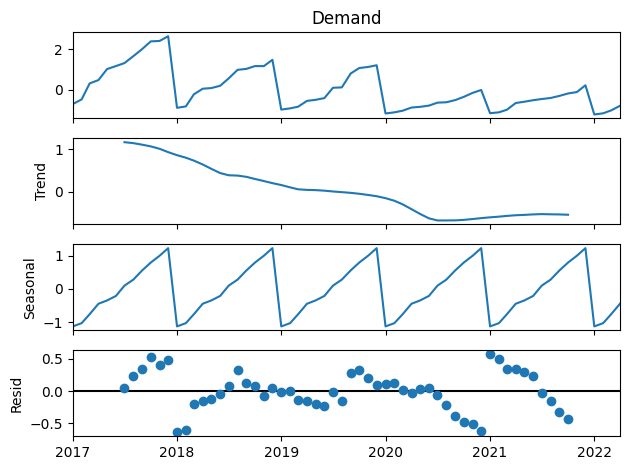

In [8]:
decomposition_additive = seasonal_decompose(df["Demand"], model="additive", period=12)

decomposition_additive.plot()
plt.show()

## Split data into training and testing sets

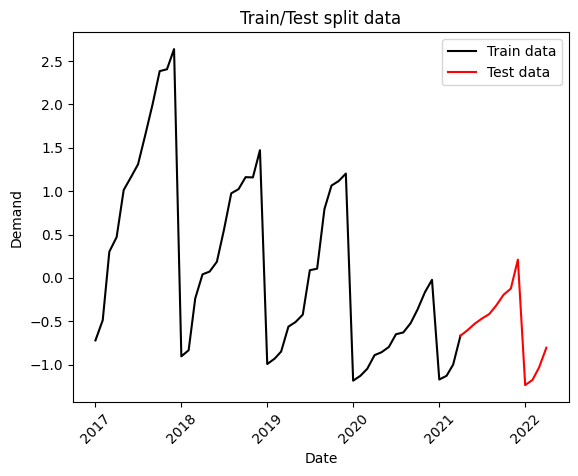

In [9]:
train_size = int(len(df) * 0.8)

train_data, test_data = df.iloc[:train_size+1], df.iloc[train_size:]

plt.plot(train_data, color = "black", label="Train data")
plt.plot(test_data, color = "red", label="Test data")
plt.ylabel('Demand')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.title("Train/Test split data")
plt.show()

## Holt-Winters Model

The Holt-Winters model, also known as the Exponential Smoothing model, is a popular method for forecasting time series data that exhibits both trend and seasonality.

Is useful for short to medium-term forecasting where the time series data has clear seasonal patterns and a trend.

In [10]:
hw_model = ExponentialSmoothing(train_data["Demand"], trend="add", seasonal="add", seasonal_periods=12)
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(len(test_data))

hw_mse = mean_squared_error(test_data["Demand"], hw_pred)
hw_mae = mean_absolute_error(test_data["Demand"], hw_pred)

print(f"Holt-Winters Metrics: \nMSE = {hw_mse} \nMAE = {hw_mae}")

Holt-Winters Metrics: 
MSE = 0.5325022250673163 
MAE = 0.5624636237495871


c:\dev\prueba_profesional_ml\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## ARIMA Model

ARIMA stands for AutoRegressive Integrated Moving Average. It is a class of models that explains a given time series based on its own past values, its own past errors (lags), and the errors of previous periods.

ARIMA is suitable for non-seasonal data or when the seasonal component has been removed.

In this case, as the time series has a seasonal component, ARIMA model will not be suitable

In [11]:
arima_model = ARIMA(train_data["Demand"], order=(1, 1, 0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test_data))

arima_mse = mean_squared_error(test_data['Demand'], arima_pred)
arima_mae = mean_absolute_error(test_data['Demand'], arima_pred)
print(f'ARIMA MSE: \nMSE = {arima_mse} \nMAE = {arima_mae}')

ARIMA MSE: 
MSE = 0.1765874029041951 
MAE = 0.34773808524931743


c:\dev\prueba_profesional_ml\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\dev\prueba_profesional_ml\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\dev\prueba_profesional_ml\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## SARIMAX Model

SARIMAX stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors. It extends the ARIMA model to support seasonal effects and the inclusion of external variables.

Is ideal for time series data with both trend and seasonality, especially when there are additional external variables that influence the series. It is useful for making more accurate forecasts by incorporating these external factors.

In [12]:
sarimax_model = SARIMAX(train_data["Demand"], order=(0, 0, 1), seasonal_order=(1, 0, 0, 12))
sarimax_fit = sarimax_model.fit()
sarimax_pred = sarimax_fit.predict(start=len(train_data), end=(len(train_data) + len(test_data) - 1), typ="levels")

sarimax_mse = mean_squared_error(test_data['Demand'], sarimax_pred)
sarimax_mae = mean_absolute_error(test_data['Demand'], sarimax_pred)
print(f'SARIMAX MSE: \nMSE = {sarimax_mse} \nMAE = {sarimax_mae}')

c:\dev\prueba_profesional_ml\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\dev\prueba_profesional_ml\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX MSE: 
MSE = 0.14777588269763922 
MAE = 0.22131729934370734


c:\dev\prueba_profesional_ml\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


## Result comparison

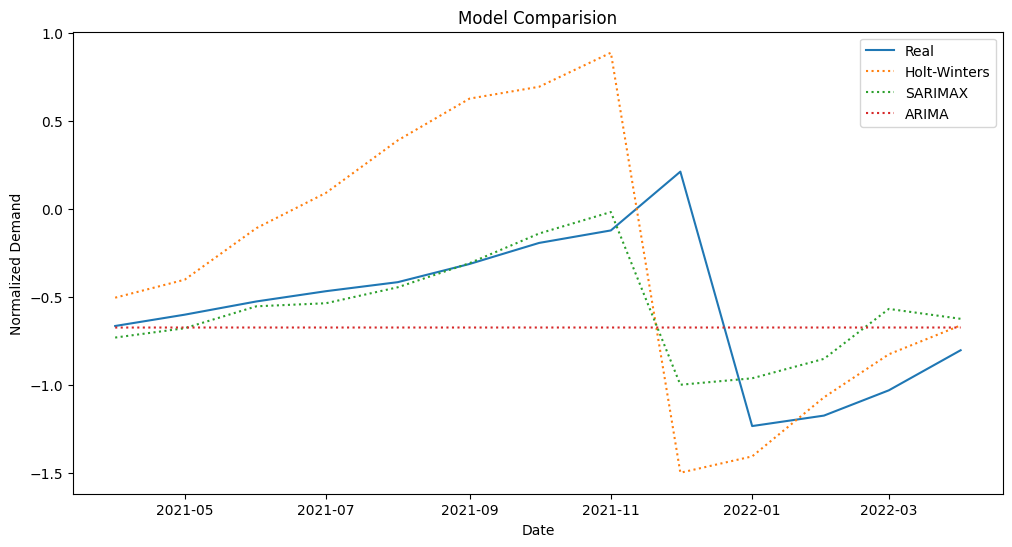

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Demand'], label='Real')
plt.plot(test_data.index, hw_pred, label='Holt-Winters', linestyle="dotted")
plt.plot(test_data.index, sarimax_pred, label='SARIMAX', linestyle="dotted")
plt.plot(test_data.index, arima_pred, label='ARIMA', linestyle="dotted")
plt.title('Model Comparision')
plt.xlabel('Date')
plt.ylabel('Normalized Demand')
plt.legend()
plt.show()

## Table of model metrics

In [14]:
metrics = pd.DataFrame({
    'Model': ['Holt-Winters', 'ARIMA', 'SARIMAX'],
    'MSE': [hw_mse, arima_mse, sarimax_mse],
    'MAE': [hw_mae, arima_mse, sarimax_mae]
})
print(metrics)

          Model       MSE       MAE
0  Holt-Winters  0.532502  0.562464
1         ARIMA  0.176587  0.176587
2       SARIMAX  0.147776  0.221317


## Forecasting next 3 months

Now we will use all models to forecast the next 3 months of the demand

In [15]:
hw_pred_future = hw_fit.forecast(len(test_data) + 2)
hw_pred_future = hw_pred_future[-3:]

print(f'Holt-Winters forecasting for the next 3 months:\n{hw_pred_future}')

Holt-Winters forecasting for the next 3 months:
2022-05-01   -0.663182
2022-06-01   -0.560982
2022-07-01   -0.267616
Freq: MS, dtype: float64


In [16]:
arima_pred_future = arima_fit.forecast(len(test_data) + 2)
arima_pred_future = arima_pred_future[-3:]

print(f'ARIMA forecasting for the next 3 months:\n{arima_pred_future}')

ARIMA forecasting for the next 3 months:
2022-05-01   -0.67526
2022-06-01   -0.67526
2022-07-01   -0.67526
Freq: MS, Name: predicted_mean, dtype: float64


In [17]:
sarimax_pred_future = sarimax_fit.predict(start=len(df), end=len(df) + 2)

print(f'SARIMAX forecasting for the next 3 months:\n{sarimax_pred_future}')

SARIMAX forecasting for the next 3 months:
2022-05-01   -0.625771
2022-06-01   -0.580486
2022-07-01   -0.473873
Freq: MS, Name: predicted_mean, dtype: float64


### Creating a dataframe based on the results

In [18]:
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq="MS")

predictions_df = pd.DataFrame(
    {
        'Holt-Winters': hw_pred_future,
        'ARIMA': arima_pred_future,
        'SARIMAX': sarimax_pred_future
    },
    index=future_dates
)

predictions_df


,Holt-Winters,ARIMA,SARIMAX
2022-05-01,-0.663182,-0.67526,-0.625771
2022-06-01,-0.560982,-0.67526,-0.580486
2022-07-01,-0.267616,-0.67526,-0.473873


In [19]:
df_predictions = df.copy()
df_predictions = pd.concat([df, predictions_df])

df_predictions.tail()

,Demand,Holt-Winters,ARIMA,SARIMAX
2022-03-01,-1.032237,NaN,NaN,NaN
2022-04-01,-0.804438,NaN,NaN,NaN
2022-05-01,NaN,-0.663182,-0.67526,-0.625771
2022-06-01,NaN,-0.560982,-0.67526,-0.580486
2022-07-01,NaN,-0.267616,-0.67526,-0.473873


### Visualize final results

Normalization results

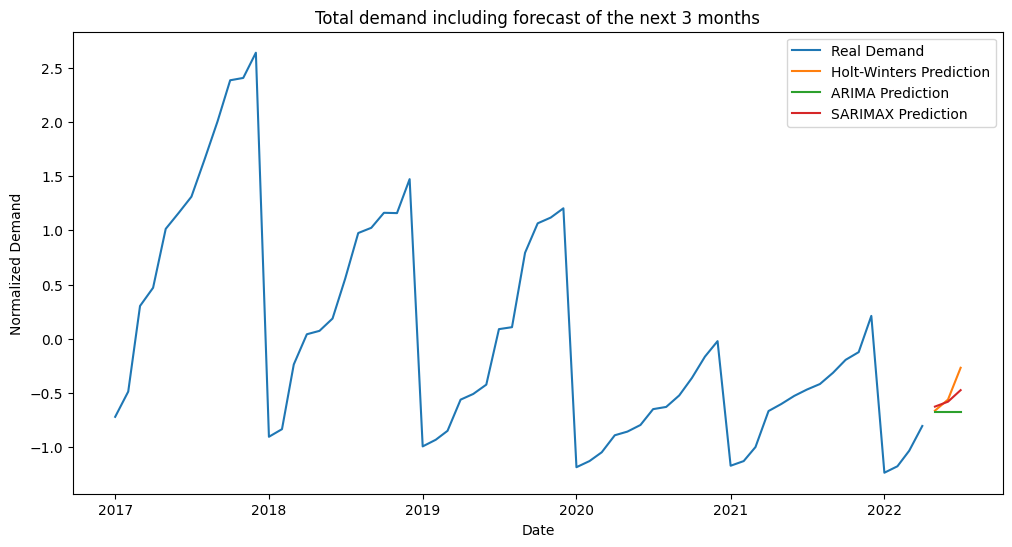

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df['Demand'], label='Real Demand')
plt.plot(df_predictions.index, df_predictions['Holt-Winters'], label='Holt-Winters Prediction')
plt.plot(df_predictions.index, df_predictions['ARIMA'], label='ARIMA Prediction')
plt.plot(df_predictions.index, df_predictions['SARIMAX'], label='SARIMAX Prediction')
plt.title('Total demand including forecast of the next 3 months')
plt.xlabel('Date')
plt.ylabel('Normalized Demand')
plt.legend()
plt.show()

Inverse normalization

In [21]:
inversed_predictions = standard_scaler.inverse_transform(predictions_df)

df_inversed_predictions = pd.DataFrame(
    {
        'Holt-Winters': inversed_predictions[:, 0],
        'ARIMA': inversed_predictions[:, 1],
        'SARIMAX': inversed_predictions[:, 2]
    },
    index=future_dates
)

In [22]:
df_inversed_predictions

,Holt-Winters,ARIMA,SARIMAX
2022-05-01,1320.933162,1297.638625,1393.089839
2022-06-01,1518.051552,1297.638625,1480.434167
2022-07-01,2083.880278,1297.638625,1686.062103


In [23]:
df_predictions_inverse = pd.concat([data, df_inversed_predictions])

df_predictions_inverse.tail()

,Demand,Holt-Winters,ARIMA,SARIMAX
2022-03-01,609.119726,NaN,NaN,NaN
2022-04-01,1048.486287,NaN,NaN,NaN
2022-05-01,NaN,1320.933162,1297.638625,1393.089839
2022-06-01,NaN,1518.051552,1297.638625,1480.434167
2022-07-01,NaN,2083.880278,1297.638625,1686.062103


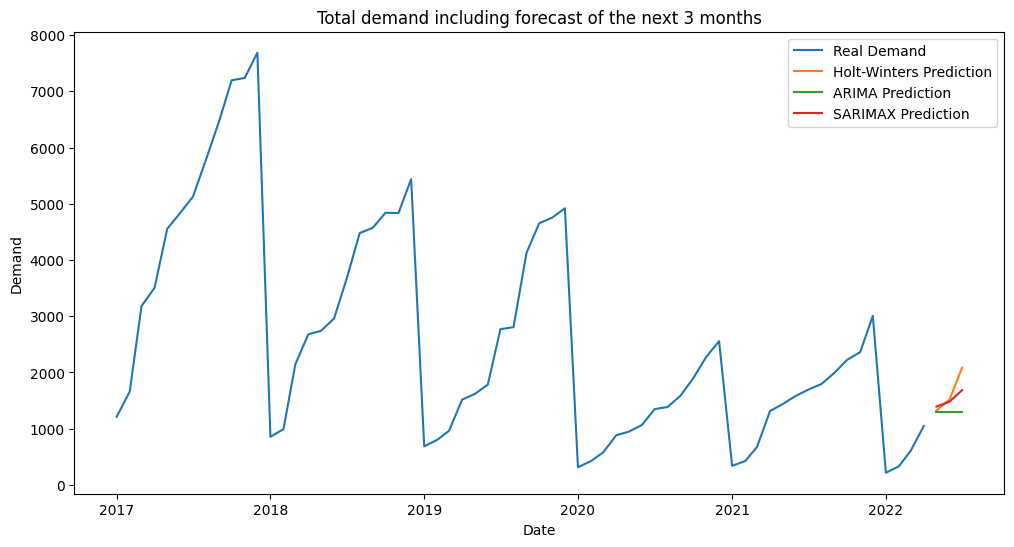

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(data['Demand'], label='Real Demand')
plt.plot(df_predictions_inverse.index, df_predictions_inverse['Holt-Winters'], label='Holt-Winters Prediction')
plt.plot(df_predictions_inverse.index, df_predictions_inverse['ARIMA'], label='ARIMA Prediction')
plt.plot(df_predictions_inverse.index, df_predictions_inverse['SARIMAX'], label='SARIMAX Prediction')
plt.title('Total demand including forecast of the next 3 months')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()